# First Example
The easiest way to run _PHRINGE_ is by the use of a config file ([see here for a config file tutorial](create_config_file.rst)). More advanced use cases might require more control over the input, which is possible by manually setting up the objects specified in the config file ([see interactive example](advanced_example.ipynb)). In this example, we simulate the observation of an Earth twin around a Sun twin at 10 pc with a basic configuration similar to LIFE.

### Import Necessary Modules

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from phringe.core.entities.configuration import Configuration

from lifesimmc.core.modules.generating.data_generation_module import DataGenerationModule
from lifesimmc.core.modules.generating.template_generation_module import TemplateGenerationModule
from lifesimmc.core.modules.loading.setup_module import SetupModule
from lifesimmc.core.modules.processing.correlation_map_module import CorrelationMapModule
from lifesimmc.core.modules.processing.ml_parameter_estimation_module import MLParameterEstimationModule
from lifesimmc.core.modules.processing.zca_whitening_calibration_star_module import ZCAWhiteningCalibrationStarModule
from lifesimmc.core.pipeline import Pipeline

In [9]:
# Create the pipeline
pipeline = Pipeline(gpu_index=2, seed=None, grid_size=40)

# Setup the simulation
module = SetupModule(n_config_out='conf', configuration=Configuration(path=Path(r"../_static/config.py")))
pipeline.add_module(module)

Loading configuration...
Done
Generating synthetic data...


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


Done


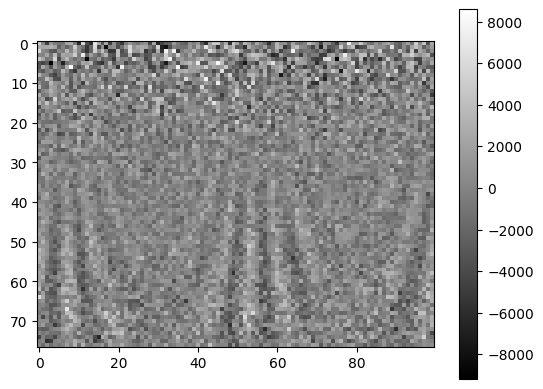

In [10]:
module = DataGenerationModule(n_config_in='conf', n_data_out='data', n_planet_params_out='params_init')
pipeline.add_module(module)
pipeline.run()

# Plot data
data = pipeline.get_resource('data').get_data()
plt.imshow(data[0].cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()

In [11]:
module = TemplateGenerationModule(n_config_in='conf', n_template_out='temp', fov=1e-6)
pipeline.add_module(module)

In [12]:
module = ZCAWhiteningCalibrationStarModule(
    n_config_in='conf',
    n_data_in='data',
    n_template_in='temp',
    n_data_out='data_white',
    n_template_out='temp_white',
    n_transformation_out='zca',
    diagonal_only=False
)
# pipeline.add_module(module)

In [13]:
module = CorrelationMapModule(n_data_in='data', n_template_in='temp', n_image_out='imag_mf')
pipeline.add_module(module)

Generating templates...
Done
Calculating correlation map...
Done
Performing numerical MLE...


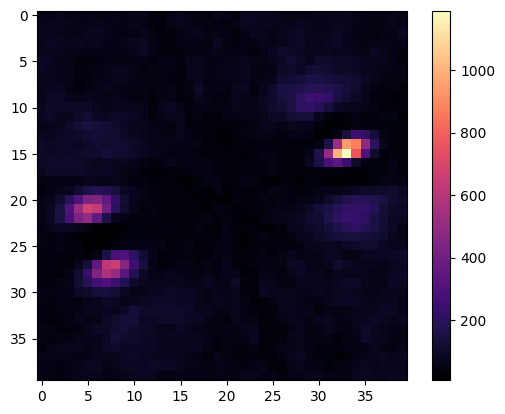

Done


In [14]:
module = MLParameterEstimationModule(
    n_config_in='conf',
    n_data_in='data',
    n_template_in='temp',
    # n_transformation_in='zca',
    n_planet_params_out='params_ml',
)
pipeline.add_module(module)
pipeline.run()

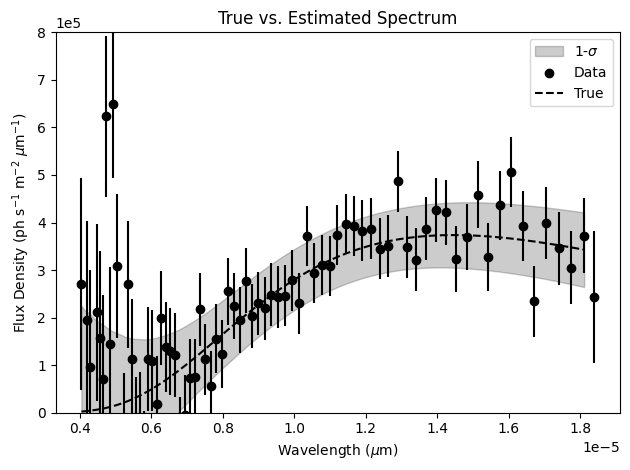

In [15]:
params_init = pipeline.get_resource('params_init')
params_ml = pipeline.get_resource('params_ml')

if params_ml is not None:
    flux = params_ml.params[0].sed.cpu().numpy()
    wl = params_ml.params[0].sed_wavelength_bin_centers.cpu().numpy()
    err_low = params_ml.params[0].sed_err_low
    err_high = params_ml.params[0].sed_err_high
    flux_init = params_init.params[0].sed.cpu().numpy()[:-1]

    if err_low is not None:
        yerr = np.stack([err_low, err_high])
        plt.errorbar(wl, flux, yerr=yerr, fmt=".k", capsize=0)
        plt.fill_between(wl[:-1], np.array(flux_init) - np.array(err_low)[:-1],
                         np.array(flux_init) + np.array(err_high)[:-1],
                         color="k", alpha=0.2, label='1-$\sigma$')
    plt.scatter(wl, flux, label='Data', color='black')
    plt.plot(wl[:-1], flux_init, label='True', color='black', linestyle='dashed')
    plt.title('True vs. Estimated Spectrum')
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Flux Density (ph s$^{-1}$ m$^{-2}$ $\mu$m$^{-1}$)')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    plt.legend()
    plt.ylim(0e6, 0.8e6)
    plt.tight_layout()
    plt.savefig('spectrum.png', dpi=300)
    plt.show()
    plt.close()